In [1]:
from numba import cuda
from matplotlib import pyplot as plt
from math import floor
import numpy as np
import time

In [2]:
if cuda.is_available(): # List devices
    devices = cuda.list_devices()
    print("GPU devices:")
    for device in devices:
        print("-", device.name)
    print("Selected device:", cuda.get_current_device().name)

GPU devices:
- b'NVIDIA GeForce RTX 3060 Laptop GPU'
Selected device: b'NVIDIA GeForce RTX 3060 Laptop GPU'


In [3]:
# 1ST XP : Incrementation of an array

GRID_SIZE = 50000 # Number of blocks in the grid
BLOCKSIZE = 1024 # Number of threads for each block

In [4]:
@cuda.jit # Indicate to Python that this function is a CUDA Kernel
def cudakernel0(array):
    thread_position = cuda.grid(1)
    array[thread_position] += 1

In [5]:
array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)

print("Icrementation of array by 1 | size:", GRID_SIZE*BLOCKSIZE)

# GPU
print('Kernel launch: cudakernel0[', GRID_SIZE, ', ', BLOCKSIZE,'](array)...', end=" ")
start = time.time()
cudakernel0[GRID_SIZE, BLOCKSIZE](array)
GPU_time = time.time() - start
print("Success")
      
print("Time spent for", GRID_SIZE*BLOCKSIZE, "incrementations:", GPU_time)

Icrementation of array by 1 | size: 51200000
Kernel launch: cudakernel0[ 50000 ,  1024 ](array)... Success
Time spent for 51200000 incrementations: 0.5302755832672119


C:\Users\arthu\anaconda3\envs\crypt\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


C:\Users\arthu\anaconda3\envs\crypt\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


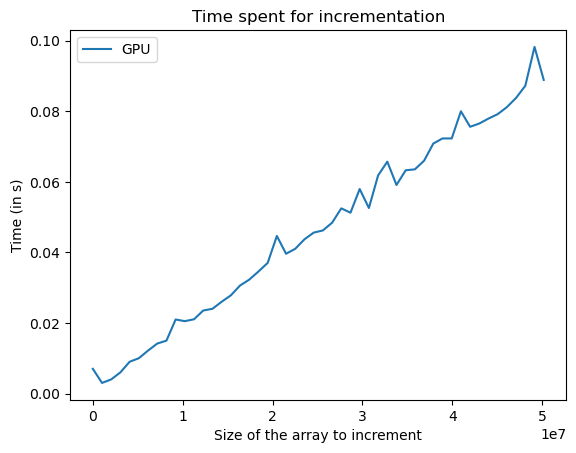

In [6]:
#Same xp as a function of the number of operations

operations = np.array([1 + i * 1000 for i in range(0, 50)])
size_op = operations.size
BLOCKSIZE = 1024

times = np.zeros((2, size_op))

for i in range(size_op):
    GRID_SIZE = operations[i]
    
    array = np.zeros(GRID_SIZE*BLOCKSIZE, np.float32)
    
    # GPU
    start = time.time()
    cudakernel0[GRID_SIZE, BLOCKSIZE](array)
    GPU_time = time.time() - start
    
    times[1, i] = GPU_time

plt.title("Time spent for incrementation")
plt.plot(operations * BLOCKSIZE, times[1], label = 'GPU')
plt.ylabel("Time (in s)")
plt.xlabel("Size of the array to increment")
plt.legend()
plt.show()

In [7]:
# 2ND XP : Matrix multiplication

GRID_SIZE = 50000 # Number of blocks in the grid
BLOCKSIZE = 1024 # Number of threads for each block

In [8]:
@cuda.jit
def cudakernel1(matrix1, matrix2, res, blocksize):
    pos = cuda.grid(1)
    block_position = (int)(pos / blocksize)
    thread_position = pos % blocksize
    
    result = 0
        
    for i in range(blocksize):
        result += matrix1[block_position, i] * matrix2[i, thread_position]
    
    res[block_position, thread_position] = result
    

In [9]:
matrix1 = np.random.rand(GRID_SIZE, BLOCKSIZE)
matrix2 = np.random.rand(BLOCKSIZE, BLOCKSIZE)

res = np.zeros((GRID_SIZE, BLOCKSIZE), np.float32)

print("Matrix multiplication, | matrix size:", matrix1.shape)

# GPU
print('Kernel launch: cudakernel1[', GRID_SIZE, ', ', BLOCKSIZE,'](array)...', end=" ")
start = time.time()
cudakernel1[GRID_SIZE, BLOCKSIZE](matrix1, matrix2, res, BLOCKSIZE)
GPU_time = time.time() - start
print("Success")
      
print("GPU time:", GPU_time)

print("Time spent to multiply matrices, 50000*1024 with 1024*1024:", GPU_time)


Matrix multiplication, | matrix size: (50000, 1024)
Kernel launch: cudakernel1[ 50000 ,  1024 ](array)... 

C:\Users\arthu\anaconda3\envs\crypt\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Success
GPU time: 1.004199504852295
Time spent to multiply matrices, 50000*1024 with 1024*1024: 1.004199504852295


C:\Users\arthu\anaconda3\envs\crypt\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


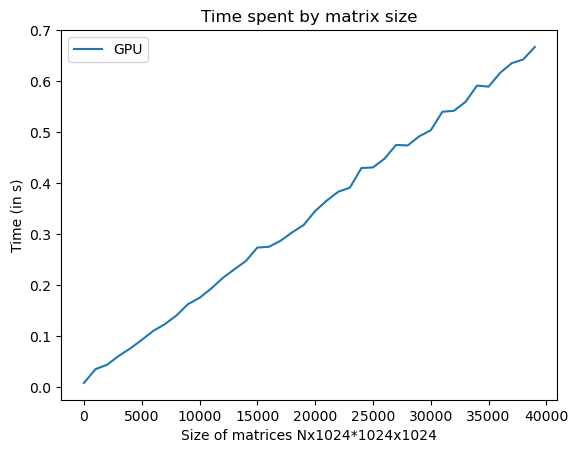

In [10]:
# Same xp as a function of the number of operations

operations = np.array([1 + i * 1000 for i in range(0, 40)])
size_op = operations.size

times = np.zeros((2, size_op))
BLOCKSIZE = 1024

for i in range(size_op):
    GRID_SIZE = operations[i]
    
    matrix1 = np.random.rand(GRID_SIZE, BLOCKSIZE)
    matrix2 = np.random.rand(BLOCKSIZE, BLOCKSIZE)

    res = np.zeros((GRID_SIZE, BLOCKSIZE), np.float32)

    # GPU
    start = time.time()
    cudakernel1[GRID_SIZE, BLOCKSIZE](matrix1, matrix2, res, BLOCKSIZE)
    GPU_time = time.time() - start
    
    times[1, i] = GPU_time

plt.title("Time spent by matrix size")
plt.plot(operations, times[1], label = 'GPU')
plt.ylabel("Time (in s)")
plt.xlabel("Size of matrices Nx1024*1024x1024")
plt.legend()
plt.show()